In [8]:
%%writefile src/task_tool.py

from typing import Annotated, NotRequired, TypedDict

from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langchain.agents import create_agent

from langgraph.types import Command

from src.prompts import TASK_DESCRIPTION_PREFIX
from src.state import DeepAgentState


class SubAgent(TypedDict):
    """Configuration for a specialized sub-agent"""

    name: str
    description: str
    prompts: str
    tools: NotRequired[list[str]]


def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

    This function implements the core pattern for spawning specialized sub-agents with
    isolated contexts, preventing context clash and confusion in complex multi-step tasks.

    Args:
        tools: List of available tools that can be assigned to sub-agents
        subagents: List of specialized sub-agent configurations
        model: The language model to use for all agents
        state_schema: The state schema (typically DeepAgentState)

    Returns:
        A 'task' tool that can delegate work to specialized sub-agents
    """
    agents = {}

    tools_by_name = {}
    for tool_ in tools:
        if not isinstance(tool_, BaseTool):
            tool_ = tool(tool_)
        tools_by_name[tool_.name] = tool_
    
    for _agent in subagents:
        if "tools" in _agent:
            _tools = [tools_by_name[t] for t in _agent["tools"]]
        else:
            _tools = tools
        agents[_agent["name"]] = create_agent(
            model, system_prompt=_agent["prompt"], tools=_tools, state_schema=state_schema
        )
    
    other_agents_string = [
        f"- {_agent['name']}: {_agent['description']}" for _agent in subagents
    ]
    @tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
    def task(
        description: str,
        subagent_type: str,
        state: Annotated[DeepAgentState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId]
    ):
        """Delegate a task to a specialized sub-agent with isolated context.

        This creates a fresh context for the sub-agent containing only the task description,
        preventing context pollution from the parent agent's conversation history.
        """
        if subagent_type not in agents:
            return f"Error: invoked agent of type {subagent_type}, the only allowed types are {[f'`{k}`' for k in agents]}"
        
        sub_agent = agents[subagent_type]

        state["messages"] = [{"role": "user", "content": description}]

        result = sub_agent.invoke(state)

        return Command(
            update={
                "files": result.get("files", {}),
                "messages": [
                    ToolMessage(
                        result["messages"][-1].content, tool_call_id=tool_call_id
                    )
                ]
            }
        )
    return task

Overwriting src/task_tool.py


In [9]:
from utils import show_prompt

from src.prompts import SUBAGENT_USAGE_INSTRUCTIONS

show_prompt(SUBAGENT_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your role is to coordinate research by delegating specific research tasks to sub-agents.                       │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  1. **task(description, subagent_type)**: Delegate research tasks to specialized sub-agents                     │
│     - description: Clear, specific research question or task                                                    │
│     - subagent_type: Type of agent to use (e.g., "research-agent")                                              │
│  2. **think_tool(reflection)**: Reflect on the results of each delegated task and plan next steps.              │
│     - reflection: Your detailed reflection on the results of the task and next steps.                           │
│                                                                                                                 │
│  **PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **task**      │
│  tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units}      │
│  parallel agents per iteration.                                                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Task Delegation Budgets** (Prevent excessive delegation):                                                    │
│  - **Bias towards focused research** - Use single agent for simple questions, multiple only when clearly        │
│  beneficial or when you have multiple independent research directions based on the user's request.              │
│  - **Stop when adequate** - Don't over-research; stop when you have sufficient information                      │
│  - **Limit iterations** - Stop after {max_researcher_iterations} task delegations if you haven't found          │
│  adequate sources                                                                                               │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  <Scaling Rules>                                                                                                │
│  **Simple fact-finding, lists, and rankings** can use a single sub-agent:                                       │
│  - *Example*: "List the top 10 coffee shops in San Francisco" → Use 1 sub-agent, store in                       │
│  `findings_coffee_shops.md`                                                                                     │
│                                                                                                                 │
│  **Comparisons** can use a sub-agent for each element 

d:\anaconda\Lib\site-packages\pydantic\_internal\_generate_schema.py:404: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
d:\anaconda\Lib\site-packages\pydantic\_internal\_generate_schema.py:404: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


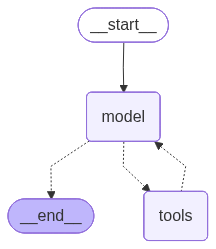

In [10]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
#from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent # updated in 1.0
from langchain_openai import ChatOpenAI

import os

from src.prompts import SUBAGENT_USAGE_INSTRUCTIONS
from src.state import DeepAgentState
from src.task_tool import _create_task_tool

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from the search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """You are a researcher. Research the topic provided to you. IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the provided topic."""


research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}

OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
if not OPENROUTER_API_KEY:
    raise EnvironmentError("Установите OPENROUTER_API_KEY в файле .env")

llm = ChatOpenAI(
    model="anthropic/claude-sonnet-4.5",
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    temperature=0.0
)

sub_agent_tools = [web_search]

task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], llm, DeepAgentState
)

delegation_tools = [task_tool]

agent = create_agent(
    model=llm,
    tools=delegation_tools,
    system_prompt=SUBAGENT_USAGE_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
        date=datetime.now().strftime("%a %b %d, %Y"),
    ),
    state_schema=DeepAgentState
)

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [11]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll research the Model Context Protocol (MCP) for you.                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research and provide a comprehensive overview of Model Context Protocol (MCP). Include what   │
│ it is, its purpose, key features, how it works, who developed it, main use cases, and its significance in the   │
│ AI/technology landscape.",                                                                                      │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_bdrk_018ev6rrFkUBsMCEkvGmecQ1                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is Model Context Protocol (MCP)?                                                                        │
│                                                                                                                 │
│ Model Context Protocol (MCP) is an **open standard protocol** that serves as a standardized communication layer │
│ between AI models and external systems. It provides a unified framework for AI assistants to interact with      │
│ various data sources, tools, databases, and services.                                                           │
│                                                                                                                 │
│ ## Developer                                                                                                    │
│                                                                                                                 │
│ **Anthropic** developed the Model Context Protocol, making it available as an open standard for the broader AI  │
│ community.                                                                                                      │
│                                                                                                                 │
│ ## Purpose                                                                                                      │
│                                                                                                                 │
│ The primary purpose of MCP is to:                                                                               │
│ - **Simplify integration** between AI models and external systems                                               │
│ - **Standardize communication** across different data sources and tools                                         │
│ - **Enable seamless data exchange** using a unified language                                                    │
│ - **Reduce complexity** in connecting AI assistants to various services                                         │
│                                                                                                                 │
│ ## Key Features                                                                                                 │
│                                                                                                                 │
│ 1. **Standardized Communication Layer**: Provides a consistent interface for AI-to-system interactions          │
│ 2. **Open Standard**: Available for widespread adoption across the AI ecosystem                                 │
│ 3. **Unified Data Exchange**: Uses a common language for communication between AI models and external resources │
│ 4. **Interoperability**: Allows AI models to access multiple types of external systems through a single         │
│ protocol                                                                                                        │
│                                                                                                                 │
│ ## How It Works                                                                                                 │
│                                                                                                                 │
│ MCP acts as an intermediary layer that:                                                                         │
│ - Establishes a standardized method for AI models to request and receive data                                   │
│ - Enables AI assistants to access tools, databases, and

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Overview of Model Context Protocol (MCP)                                                                     │
│                                                                                                                 │
│ Based on my research, here's a comprehensive overview:                                                          │
│                                                                                                                 │
│ ### **What is MCP?**                                                                                            │
│ Model Context Protocol (MCP) is an **open standard protocol** developed by **Anthropic** that serves as a       │
│ standardized communication layer between AI models and external systems. It provides a unified framework for AI │
│ assistants to interact with various data sources, tools, databases, and services.                               │
│                                                                                                                 │
│ ### **Purpose**                                                                                                 │
│ MCP was created to:                                                                                             │
│ - Simplify integration between AI models and external systems                                                   │
│ - Standardize communication across different data sources and tools                                             │
│ - Enable seamless data exchange using a unified language                                                        │
│ - Reduce the complexity of connecting AI assistants to various services                                         │
│                                                                                                                 │
│ ### **Key Features**                                                                                            │
│ 1. **Standardized Communication Layer** - Provides a consistent interface for AI-to-system interactions         │
│ 2. **Open Standard** - Available for widespread adoption across the AI ecosystem                                │
│ 3. **Unified Data Exchange** - Uses a common language for communication                                         │
│ 4. **Interoperability** - Allows AI models to access multiple types of external systems through a single        │
│ protocol                                                                                                        │
│                                                                                                                 │
│ ### **How It Works**                                                                                            │
│ MCP acts as an intermediary layer that:                                                                         │
│ - Establishes standardized methods for AI models to request and receive data                                    │
│ - Enables AI assistants to access tools, databases, and services consistently                                   │
│ - Facilitates efficient data exchange without requiring custom integrations for each service                    │
│ - Provides a common framework that both AI models and external systems understand                               │
│                                                                                                                 │
│ ### **Main Use Cases**                                                                                          │
│ - Database integration and data retrieval                                                                       │
│ - External tool and service access                                                                              │
│ - Multi-source data aggregation                        